In [ ]:
# default_exp text.modeling.core
# default_cls_lvl 3


In [ ]:
# all_slow


In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# text.modeling.core

> This module contains core custom models, loss functions, and a default layer group splitter for use in applying discriminiative learning rates to your Hugging Face models trained via fastai

In [ ]:
# export
import os, inspect, mimetypes
from typing import Any, Callable, Dict, List, Optional, Union, Type

from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, CategoryBlock, MultiCategoryBlock, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoModelForSequenceClassification, PreTrainedModel, logging

from blurr.text.data.core import TextBlock, TextInput, first_blurr_tfm
from blurr.text.utils import get_hf_objects
from blurr.utils import PreCalculatedLoss, PreCalculatedBCELoss, PreCalculatedCrossEntropyLoss, PreCalculatedMSELoss, set_seed

logging.set_verbosity_error()


In [ ]:
# hide_input
import pdb

from datasets import concatenate_datasets, load_dataset
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbdev.showdoc import show_doc

from blurr.text.data.core import TextDataLoader
from blurr.text.utils import BlurrText
from blurr.utils import print_versions

NLP = BlurrText()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")


What we're running with at the time this documentation was generated:
torch: 1.11.0
fastai: 2.6.0
transformers: 4.18.0


In [ ]:
# hide
# cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")


Using GPU #1: NVIDIA GeForce RTX 3080


## Mid-level API

Base splitter, model wrapper, and model callback

### `blurr_splitter` -

In [ ]:
# export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)


In [ ]:
show_doc(blurr_splitter, title_level=3)


<h4 id="blurr_splitter" class="doc_header"><code>blurr_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>blurr_splitter</code>(**`m`**:`Module`)

Splits the Hugging Face model based on various model architecture conventions

### `BaseModelWrapper` -

In [ ]:
# export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs
        )


Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# export
class BaseModelCallback(Callback):
    def before_fit(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model)
            self.was_wrapped = False
        elif isinstance(self.learn.model, BaseModelWrapper):
            self.was_wrapped = True

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()
    
    def after_fit(self):
       if not self.was_wrapped:
            self.learn.model = self.learn.model.hf_model           


In [ ]:
# export
class BaseModelCallback(Callback):
    def before_fit(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model)
            self.was_wrapped = False
        elif isinstance(self.learn.model, BaseModelWrapper):
            self.was_wrapped = True

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()
    
    def after_fit(self):
       if not self.was_wrapped:
            self.learn.model = self.learn.model.hf_model           


In [ ]:
# export
class BaseModelCallback(Callback):
    def before_fit(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model)
            self.was_wrapped = False
        elif isinstance(self.learn.model, BaseModelWrapper):
            self.was_wrapped = True

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()
    
    def after_fit(self):
        if not self.was_wrapped:
            self.learn.model = self.learn.model.hf_model           


In [ ]:
# export
class BaseModelCallback(Callback):
    def before_fit(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model)
            self.was_wrapped = False
        elif isinstance(self.learn.model, BaseModelWrapper):
            self.was_wrapped = True

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()
    
    def after_fit(self):
       if not self.was_wrapped:
            self.learn.model = self.learn.model.hf_model           


In [ ]:
# export
class BaseModelCallback(Callback):
    def before_fit(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model)
            self.was_wrapped = False
        elif isinstance(self.learn.model, BaseModelWrapper):
            self.was_wrapped = True

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()
    
    def after_fit(self):
       if not self.was_wrapped:
            self.learn.model = self.learn.model.hf_model           


We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

### Example

Below demonstrates how to setup your pipeline for a sequence classification task (e.g., a model that requires a single text input) using the mid, high, and low-level API

In [ ]:
raw_datasets = load_dataset("imdb", split=["train", "test"])
raw_datasets[0] = raw_datasets[0].add_column("is_valid", [False] * len(raw_datasets[0]))
raw_datasets[1] = raw_datasets[1].add_column("is_valid", [True] * len(raw_datasets[1]))

final_ds = concatenate_datasets([raw_datasets[0].shuffle().select(range(1000)), raw_datasets[1].shuffle().select(range(200))])
imdb_df = pd.DataFrame(final_ds)
imdb_df.head()


Reusing dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-d7fa5c9b748166d2.arrow
Loading cached shuffled indices for dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-c5f1241ea667d1dc.arrow


,text,label,is_valid
0,"Ah, the sex-and-gore movie. It's too bad they don't make these anymore (unless you live in Japan). But if they all turned out like this, that is not a bad thing.<br /><br />The movie basically consists of the two lovely vampires picking up ""johns"" along a country road, taking them home to their castle, having crazy sex with them, and then eating them (except the first victim, who they keep around for no particular reason). Things are complicated when a woman camping with her husband becomes too curious about these mysterious women she keeps seeing. It gets real ugly from here. By the end, ...",0,False
1,"This is the film in Antonioni's middle period that most critics dismiss quickly, as a 'flawed' look at 60s American youth culture/politics. For what it's worth, I found it more touching and memorable than his more acclaimed films like L'AVVENTURA, perhaps because he shows more emotion & empathy here than anywhere else. The story is simple, but it is used as a frame for Antonioni's brilliant observations of, and critique on American consumerist culture, student life, the counter-culture, and the whole anti-establishment, anti-war backlash that was so prominent then. <br /><br />Even from a ...",1,False
2,"This is the definitive movie version of Hamlet. Branagh cuts nothing, but there are no wasted moments.",1,False
3,i thought it was pretty interesting my social studies/language arts teacher was the police chief guy that was holding the microphone on the water barrel part =D i was excited my teacher is in some commercials he was in a gas/coffee/phone/play station commercial its nice seeing him on TV he was also on everybody hates Chris except he always get the small part la la why do we have to right 10 lines thats so stupid -_- i think I'm done never mind I'm still not done what is this a joke? why do we have to go all the way to line ten... really what's the point of it??!! i will just right random w...,1,False
4,"What a dog of a movie. Noni Hazelhurst's performance is quite good, but it sits amidst a jungle of abhorrent scriptwriting, mediocre direction and wooden acting from the bulk of the cast. Many of the characters are woefully miscast, particularly the ever overrated Colin Friels.<br /><br />Very little works in this pretentious garbage. Much of the ""character development"" is done through a silly, angst-ridden voice over and frequently completely contradicts the behaviour of characters on-screen. In fact, it's hard to even figure out who the voice overs are talking about because they describe...",0,False


In [ ]:
labels = raw_datasets[0].features["label"].names
labels


['neg', 'pos']

In [ ]:
# hide_output
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"  # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls)


In [ ]:
# single input
set_seed()
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, batch_tokenize_kwargs={"labels": labels}), CategoryBlock)
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader("label"), splitter=RandomSplitter(seed=42))


In [ ]:
# hide
# dblock.summary(imdb_df)


In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)


In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)


,text,target
0,"With Iphigenia, Mikhali Cacoyannis is perhaps the first film director to have successfully brought the feel of ancient Greek theatre to the screen. His own screenplay, an adaptation of Euripides' tragedy, was far from easy, compared to that of the other two films of the trilogy he directed. The story has been very carefully deconstructed from Euripides' version and placed in a logical, strictly chronological framework, better conforming to the modern methods of cinematic story-telling. Cacoyann",pos
1,"This comment does contain spoilers!!<br /><br />There are few actors that have an intangible to them. That innate quality which is an amalgamation of charisma, panache and swagger. It's the quality that can separate good actors from the truly great. I think George Clooney has it and so does Jack Nicholson. You can look at Clooney's subtle touches in scenes like his one word good-bye to Andy Garcia in Ocean's 11 when they just utter each other's name disdainfully. ""Terry."" ""Danny."" You can pick",pos


#### Training

`.to_fp16()` requires a GPU so had to remove for tests to run on github.  Let's check that we can get predictions.

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter,
)

learn.freeze()


In [ ]:
# hide_output
learn.summary()


BaseModelWrapper (Input shape: 4 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 512 x 768       
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
         

In [ ]:
print(len(learn.opt.param_groups))


3


SuggestedLRs(minimum=8.317637839354575e-05, steep=0.033113110810518265, valley=0.00015848931798245758, slide=0.001737800776027143)

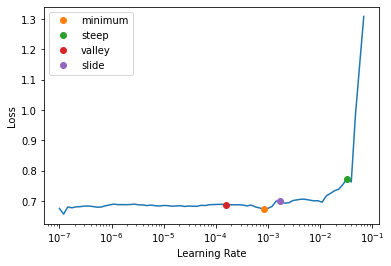

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


In [ ]:
set_seed()
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.325592,0.345017,0.862500,00:13


#### Showing results

And here we create a `@typedispatch`ed implementation of `Learner.show_results`.

In [ ]:
# export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    res = L()
    n_inp = learner.dls.n_inp

    for idx, (input_ids, label, pred, sample) in enumerate(zip(x, y, outs, samples)):
        if idx >= max_n:
            break

        # add in the input text
        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        # add in the targets
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                trg = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.numpy()
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        # add in the predictions
        for item in pred:
            if not torch.is_tensor(item):
                p = trg_labels[int(item)] if trg_labels else item
            elif is_listy(item.tolist()):
                p = [trg_labels[idx] for idx, val in enumerate(item.numpy().tolist()) if (val == 1)] if (trg_labels) else item.numpy()
            else:
                p = trg_labels[item.item()] if (trg_labels) else item.item()

            rets.append(p)

        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp * 2)]
    cols += ["prediction" if (i == 0) else f"prediction_{i}" for i in range(len(res[0]) - n_inp * 2)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to h",pos,pos
1,"THE SHOP AROUND THE CORNER is one of the sweetest and most feel-good romantic comedies ever made. There's just no getting around that, and it's hard to actually put one's feeling for this film into words. It's not one of those films that tries too hard, nor does it come up with the oddest possible scenarios to get the two protagonists together in the end. In fact, all its charm is innate, contained within the characters and the setting and the plot... which is highly believable to boot. It's ea",pos,pos


In [ ]:
learn.unfreeze()


In [ ]:
set_seed()
learn.fit_one_cycle(2, lr_max=slice(1e-7, 1e-4))


epoch,train_loss,valid_loss,accuracy,time
0,0.283300,0.308957,0.883333,00:20
1,0.199706,0.322771,0.862500,00:21


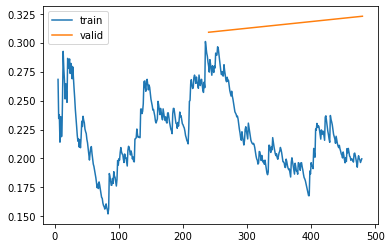

In [ ]:
learn.recorder.plot_loss()


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to h",pos,pos
1,"Feroz Abbas Khan's Gandhi My Father, a film that sheds light on the fractured relationship between the Mahatma and his son Harilal Gandhi. For a story that's as dramatic as the one this film attempts to tell, it's a pity the director fails to tell it dramatically. Gandhi My Father is narrated to you like that boring history lesson that put you to sleep at school. Now the film aims to convey one very interesting point - the fact that Gandhi in his attempt to be a fair person, ended up being an u",pos,neg


#### Prediction

We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
# export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)
    trg_labels = tfm.kwargs["labels"] if ("labels" in tfm.kwargs) else None

    is_split_str = tfm.is_split_into_words and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]

    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp :]

    outs = []
    is_multilabel = isinstance(self.loss_func, BCEWithLogitsLossFlat)
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])[0]
        if trg_labels:
            item_dec_labels = [trg_labels[int(lbl)] for item in item_dec_labels for lbl in item]

        res = {}
        if is_multilabel:
            res["labels"] = list(item_dec_labels)
            msk = item_dec_preds[0]
            res["scores"] = item_probs[0][msk].tolist()
            res["class_indices"] = [int(val) for val in item_dec_preds[0]]
        else:
            res["label"] = item_dec_labels[0]
            res["score"] = item_probs[0].tolist()[item_dec_preds[0]]
            res["class_index"] = item_dec_preds[0].item()

        res["class_labels"] = trg_labels if trg_labels else self.dls.vocab
        res["probs"] = item_probs[0].tolist()

        outs.append(res)

        # outs.append((item_dec_labels, [p.tolist() if p.dim() > 0 else p.item() for p in item_dec_preds], [p.tolist() for p in item_probs]))

    return outs


In [ ]:
show_doc(Learner.blurr_predict)


<h4 id="Learner.blurr_predict" class="doc_header"><code>Learner.blurr_predict</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_predict</code>(**`items`**, **`rm_type_tfms`**=*`None`*)



In [ ]:
learn.blurr_predict("I really liked the movie")


[{'label': 'pos',
  'score': 0.9268715381622314,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.07312848418951035, 0.9268715381622314]}]

In [ ]:
learn.blurr_predict("Acting was so bad it was almost funny.")


[{'label': 'neg',
  'score': 0.951835036277771,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.951835036277771, 0.04816494137048721]}]

In [ ]:
learn.blurr_predict(["I really liked the movie", "I really hated the movie"])


[{'label': 'pos',
  'score': 0.9268715977668762,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.07312841713428497, 0.9268715977668762]},
 {'label': 'neg',
  'score': 0.7611569762229919,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.7611569762229919, 0.23884305357933044]}]

#### Text generation

Though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# export
@patch
def blurr_generate(self: Learner, items, key="generated_texts", **kwargs):
    """Uses the built-in `generate` method to generate the text
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    if not is_listy(items):
        items = [items]

    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    results = []
    for idx, inp in enumerate(items):
        if isinstance(inp, str):
            input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
        else:
            # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
            input_ids = inp.as_subclass(Tensor)

        input_ids = input_ids.to(self.model.hf_model.device)

        gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
        outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

        if tfm.hf_arch == "pegasus":
            outputs = [o.replace("<n>", " ") for o in outputs]

        results.append({key: outputs[0] if len(outputs) == 1 else outputs})

    return results


In [ ]:
show_doc(Learner.blurr_generate)


<h4 id="Learner.blurr_generate" class="doc_header"><code>Learner.blurr_generate</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_generate</code>(**`items`**, **`key`**=*`'generated_texts'`*, **\*\*`kwargs`**)

Uses the built-in `generate` method to generate the text
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

#### Inference

Using fast.ai `Learner.export` and `load_learner`

In [ ]:
export_fname = "seq_class_learn_export"


In [ ]:
learn.export(fname=f"{export_fname}.pkl")


In [ ]:
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")


[{'label': 'neg',
  'score': 0.9319486618041992,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.9319486618041992, 0.0680513009428978]}]

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


## High-level API

#### `Blearner` -

In [ ]:
# hide_output
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"  # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls)

dls = dblock.dataloaders(imdb_df, bs=4)


In [ ]:
# export
@delegates(Learner.__init__)
class Blearner(Learner):
    def __init__(
        self,
        # Your fastai DataLoaders
        dls: DataLoaders,
        # Your pretrained Hugging Face transformer
        hf_model: PreTrainedModel,
        # Your `BaseModelCallback`
        base_model_cb: BaseModelCallback = BaseModelCallback,
        # Any kwargs you want to pass to your `BLearner`
        **kwargs
    ) -> Learner:
        """
        Returns a Blurr friendly `Learner` ready for model training
        """
        model = kwargs.get("model", BaseModelWrapper(hf_model))
        splitter = kwargs.pop("splitter", blurr_splitter)
        loss_func = kwargs.pop("loss_func", dls.loss_func if hasattr(dls, "loss_func") else None)

        # if we are letting the Hugging Face model calculate the loss for us (which is the default), we update
        # our loss function here to simply used the correct `PrecalculatedLoss`
        tfm = first_blurr_tfm(dls)
        if hasattr(tfm, "include_labels") and tfm.include_labels:
            if isinstance(loss_func, CrossEntropyLossFlat):
                loss_func = PreCalculatedCrossEntropyLoss()
            elif isinstance(loss_func, BCEWithLogitsLossFlat):
                loss_func = PreCalculatedBCELoss()
            elif isinstance(loss_func.func, nn.MSELoss):
                loss_func = PreCalculatedMSELoss()

        super().__init__(dls, model=model, loss_func=loss_func, splitter=splitter, **kwargs)

        self.add_cb(base_model_cb)
        self.freeze()


Instead of constructing our low-level `Learner`, we can use the `Blearner` class which provides sensible defaults for training

In [ ]:
learn = Blearner(dls, hf_model, metrics=[accuracy])


In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.304205,0.334683,0.854167,00:13


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to h",pos,pos
1,"THE SHOP AROUND THE CORNER is one of the sweetest and most feel-good romantic comedies ever made. There's just no getting around that, and it's hard to actually put one's feeling for this film into words. It's not one of those films that tries too hard, nor does it come up with the oddest possible scenarios to get the two protagonists together in the end. In fact, all its charm is innate, contained within the characters and the setting and the plot... which is highly believable to boot. It's ea",pos,pos


In [ ]:
learn.blurr_predict("This was a really good movie")


[{'label': 'pos',
  'score': 0.9181244969367981,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.08187545090913773, 0.9181244969367981]}]

In [ ]:
learn.export(fname=f"{export_fname}.pkl")
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")


[{'label': 'neg',
  'score': 0.9200975894927979,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.9200975894927979, 0.07990235835313797]}]

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


#### `BlearnerForSequenceClassification` -

In [ ]:
# export
@delegates(Blearner.__init__)
class BlearnerForSequenceClassification(Blearner):
    def __init__(self, dls: DataLoaders, hf_model: PreTrainedModel, **kwargs):
        super().__init__(dls, hf_model, **kwargs)

    def predict(self, text):
        return self.blurr_predict(text)

    @classmethod
    def get_model_cls(self):
        return AutoModelForSequenceClassification

    @classmethod
    def _get_x(cls, r, attr):
        return r[attr] if (isinstance(attr, str)) else tuple(r[inp] for inp in attr)

    @classmethod
    def _get_y(cls, r, attr):
        return r[attr] if (isinstance(attr, str)) else [r[inp] for inp in attr]

    @classmethod
    def from_data(
        cls,
        # Your raw dataset. Supports DataFrames, Hugging Face Datasets, as well as file paths
        # to .csv, .xlsx, .xls, and .jsonl files
        data: Union[pd.DataFrame, Path, str, List[Dict]],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # The attribute in your dataset that contains your labels/targets
        label_attr: str = "label",
        # The number of labels/classes your model should predict
        n_labels: Optional[int] = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Optional[Callable] = None,
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs: dict = {},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs: dict = {},
    ):
        # if we get a path/str then we're loading something like a .csv file
        if isinstance(data, Path) or isinstance(data, str):
            content_type = mimetypes.guess_type(data)[0]
            if content_type == "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet":
                data = pd.read_excel(data)
            elif content_type == "text/csv":
                data = pd.read_csv(data)
            elif content_type == "application/json":
                data = pd.read_json(data, orient="records")
            else:
                raise ValueError("'data' must be a .xlsx, .xls, .csv, or .jsonl file")

            data = pd.read_csv(data)

        # we need to tell transformer how many labels/classes to expect
        if n_labels is None:
            if isinstance(data, pd.DataFrame):
                n_labels = len(label_attr) if (is_listy(label_attr)) else len(data[label_attr].unique())
            else:
                n_labels = len(label_attr) if (is_listy(label_attr)) else len(set([item[label_attr] for item in data]))

        # infer our datablock splitter if None
        if dblock_splitter is None:
            dblock_splitter = ColSplitter() if hasattr(data, "is_valid") else RandomSplitter()

        # get our hf objects
        hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
            pretrained_model_name_or_path, model_cls=cls.get_model_cls(), config_kwargs={"num_labels": n_labels}
        )

        # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
        if hf_tokenizer.pad_token is None:
            hf_tokenizer.add_special_tokens({"pad_token": "<pad>"})
            hf_config.pad_token_id = hf_tokenizer.get_vocab()["<pad>"]
            hf_model.resize_token_embeddings(len(hf_tokenizer))

        # infer loss function and default metrics
        if is_listy(label_attr):
            trg_block = MultiCategoryBlock(encoded=True, vocab=label_attr)
            learner_kwargs["metrics"] = learner_kwargs.get("metrics", [F1ScoreMulti(), accuracy_multi])
        else:
            trg_block = CategoryBlock
            learner_kwargs["metrics"] = learner_kwargs.get("metrics", [F1Score(), accuracy])

        # build our DataBlock and DataLoaders
        blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), trg_block)
        dblock = DataBlock(
            blocks=blocks, get_x=partial(cls._get_x, attr=text_attr), get_y=partial(cls._get_y, attr=label_attr), splitter=dblock_splitter
        )

        dls = dblock.dataloaders(data, **dl_kwargs.copy())

        # return BLearner instance
        return cls(dls, hf_model, **learner_kwargs.copy())


We also introduce a classification task specific `Blearner` that get you your DataBlock, DataLoaders, and BLearner in one line of code!

### Examples

#### Using Mid-level API building blocks

In [ ]:
learn = BlearnerForSequenceClassification.from_data(
    imdb_df, "distilroberta-base", text_attr="text", label_attr="label", dl_kwargs={"bs": 4}
)


In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.277279,0.241745,0.932203,0.920000,00:14


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"This is one of those films where it is easy to see how some people wouldn't like it. My wife has never seen it, and when I just rewatched it last night, I waited until after she went to bed. She might have been amused by a couple small snippets, but I know she would have had enough within ten minutes.<br /><br />Head has nothing like a conventional story. The film is firmly mired in the psychedelic era. It could be seen as filmic surrealism in a nutshell, or as something of a postmodern acid tr",1,0
1,"The opening night for the 'South Asian International Film Festival' (SAIFF) in New York was an event a lot of us were waiting for.<br /><br />I would finally get to watch 'Hari Om'  I was tired of watching the ""promo"" on a loop and the lingering taste of the song Angel by Nitin Sawhney in the promo, left me begging to hear the rest of it. I was impressed by the visuals and tremendously curious about how the rugged looking auto rickshaw driver would win the hearts of the stunning sophisticated",1,1


In [ ]:
learn.predict("This was a really good movie")


[{'label': '1',
  'score': 0.886829137802124,
  'class_index': 1,
  'class_labels': [0, 1],
  'probs': [0.11317088454961777, 0.886829137802124]}]

In [ ]:
learn.export(fname=f"{export_fname}.pkl")
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")


[{'label': '0',
  'score': 0.920820951461792,
  'class_index': 0,
  'class_labels': [0, 1],
  'probs': [0.920820951461792, 0.07917908579111099]}]

#### Using Low-level API building blocks

Thanks to the `TextDataLoader`, there isn't really anything you have to do to use plain ol' PyTorch or fast.ai `Dataset`s and `DataLoaders` with Blurr.  Let's take a look at fine-tuning a model against Glue's MRPC dataset ...

##### Build your Hugging Face objects

In [ ]:
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"  # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls)


##### Preprocess your data

In [ ]:
from datasets import load_dataset
from blurr.text.data.core import preproc_hf_dataset

raw_datasets = load_dataset("glue", "mrpc")


Reusing dataset glue (/home/wgilliam/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def tokenize_function(example):
    return hf_tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)


Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-f3774ba9358a732c.arrow
Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-84263331ad583603.arrow
Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-b7fe644c800de3c0.arrow


##### Build your `DataLoaders`

In [ ]:
label_names = raw_datasets["train"].features["label"].names

trn_dl = TextDataLoader(
    tokenized_datasets["train"],
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    preproccesing_func=preproc_hf_dataset,
    batch_decode_kwargs={"labels": label_names},
    shuffle=True,
    batch_size=8,
)

val_dl = TextDataLoader(
    tokenized_datasets["validation"],
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    preproccesing_func=preproc_hf_dataset,
    batch_decode_kwargs={"labels": label_names},
    batch_size=16,
)

dls = DataLoaders(trn_dl, val_dl)


##### Define your `Blearner`

In [ ]:
learn = BlearnerForSequenceClassification(dls, hf_model, loss_func=PreCalculatedCrossEntropyLoss())


##### Train

SuggestedLRs(valley=9.120108734350652e-05)

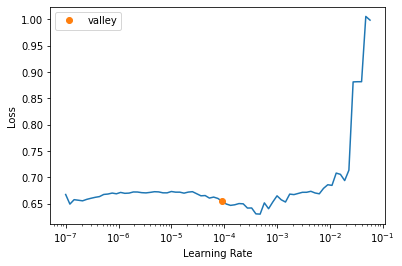

In [ ]:
learn.lr_find()


In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,time
0,0.509355,0.475181,00:13


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-8, 1e-6))


epoch,train_loss,valid_loss,time
0,0.509265,0.475472,00:26
1,0.484401,0.474938,00:26


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"Spansion products are to be available from both AMD and Fujitsu, AMD said. Spansion Flash memory solutions are available worldwide from AMD and Fujitsu.",equivalent,equivalent
1,"However, EPA officials would not confirm the 20 percent figure. Only in the past few weeks have officials settled on the 20 percent figure.",not_equivalent,equivalent


## Tests

The tests below to ensure the core training code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


In [ ]:
# hide
[model_type for model_type in NLP.get_models(task="SequenceClassification") if (not model_type.startswith("TF"))]


['AlbertForSequenceClassification',
 'BartForSequenceClassification',
 'BertForSequenceClassification',
 'BigBirdForSequenceClassification',
 'BigBirdPegasusForSequenceClassification',
 'CTRLForSequenceClassification',
 'CamembertForSequenceClassification',
 'CanineForSequenceClassification',
 'ConvBertForSequenceClassification',
 'DebertaForSequenceClassification',
 'DebertaV2ForSequenceClassification',
 'DistilBertForSequenceClassification',
 'ElectraForSequenceClassification',
 'FNetForSequenceClassification',
 'FlaubertForSequenceClassification',
 'FunnelForSequenceClassification',
 'GPT2ForSequenceClassification',
 'GPTJForSequenceClassification',
 'GPTNeoForSequenceClassification',
 'HubertForSequenceClassification',
 'IBertForSequenceClassification',
 'LEDForSequenceClassification',
 'LayoutLMForSequenceClassification',
 'LayoutLMv2ForSequenceClassification',
 'LongformerForSequenceClassification',
 'MBartForSequenceClassification',
 'MPNetForSequenceClassification',
 'MegatronB

In [ ]:
# hide
pretrained_model_names = [
    "hf-internal-testing/tiny-albert",
    "hf-internal-testing/tiny-random-bart",
    "hf-internal-testing/tiny-bert",
    "google/bigbird-roberta-base",
    "google/bigbird-pegasus-large-arxiv",
    "hf-internal-testing/tiny-random-ctrl",
    "camembert-base",
    "hf-internal-testing/tiny-random-canine",
    "YituTech/conv-bert-base",
    "hf-internal-testing/tiny-deberta",
    "hf-internal-testing/tiny-random-deberta-v2",
    "hf-internal-testing/tiny-random-distilbert",
    "hf-internal-testing/tiny-electra",
    "google/fnet-base",
    "hf-internal-testing/tiny-random-flaubert",
    "hf-internal-testing/tiny-random-funnel",
    "hf-internal-testing/tiny-random-gpt2",
    "anton-l/gpt-j-tiny-random",
    "hf-internal-testing/tiny-random-gpt_neo",
    "kssteven/ibert-roberta-base",
    "hf-internal-testing/tiny-random-led",
    "hf-internal-testing/tiny-random-longformer",
    "hf-internal-testing/tiny-random-mbart",
    "hf-internal-testing/tiny-random-mpnet",
    # "nvidia/megatron-bert-cased-345m",                 could not test
    "hf-internal-testing/tiny-random-mobilebert",
    "openai-gpt",
    "google/reformer-crime-and-punishment",
    "google/rembert",
    "junnyu/roformer_chinese_sim_char_ft_small",
    "roberta-base",
    "squeezebert/squeezebert-uncased",
    "hf-internal-testing/tiny-random-transfo-xl",
    "xlm-mlm-en-2048",
    "xlm-roberta-base",
    "xlnet-base-cased",
]


In [ ]:
# hide
raw_datasets = load_dataset("imdb", split=["train", "test"])
raw_datasets[0] = raw_datasets[0].add_column("is_valid", [False] * len(raw_datasets[0]))
raw_datasets[1] = raw_datasets[1].add_column("is_valid", [True] * len(raw_datasets[1]))

final_ds = concatenate_datasets([raw_datasets[0].shuffle().select(range(1000)), raw_datasets[1].shuffle().select(range(200))])
imdb_df = pd.DataFrame(final_ds)


Reusing dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-bb082f8a90ea273a.arrow
Loading cached shuffled indices for dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-5a941c558a0690b2.arrow


In [ ]:
# hide
from transformers import RobertaTokenizer

model_cls = AutoModelForSequenceClassification
bsz = 2
seq_sz = 32

test_results = []
for model_name in pretrained_model_names:
    error = None

    print(f"=== {model_name} ===\n")

    # 1. get/configure our Hugging Face objects
    tok_class = RobertaTokenizer if ("/ibert" in model_name) else None

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
        model_name, model_cls=model_cls, tokenizer_cls=tok_class, config_kwargs={"num_labels": 2}
    )

    print(f"architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n")

    # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
    if hf_tokenizer.pad_token is None:
        hf_tokenizer.add_special_tokens({"pad_token": "<pad>"})
        hf_config.pad_token_id = hf_tokenizer.get_vocab()["<pad>"]
        hf_model.resize_token_embeddings(len(hf_tokenizer))

    try:
        learn = None

        # 2. get our DataLoaders
        blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=seq_sz, padding="max_length"), CategoryBlock)

        dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader("label"), splitter=ColSplitter(col="is_valid"))

        dls = dblock.dataloaders(imdb_df, bs=bsz)

        # 3. configure our Learner
        model = BaseModelWrapper(hf_model)
        learn = Learner(
            dls,
            model,
            opt_func=partial(Adam),
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy],
            cbs=[BaseModelCallback],
            splitter=blurr_splitter,
        )

        learn.freeze()

        b = dls.one_batch()

        # 4. train
        print("*** TESTING DataLoaders ***")
        test_eq(len(b), bsz)
        test_eq(len(b[0]["input_ids"]), bsz)
        test_eq(b[0]["input_ids"].shape, torch.Size([bsz, seq_sz]))
        test_eq(len(b[1]), bsz)

        #         print('*** TESTING One pass through the model ***')
        #         preds = learn.model(b[0])
        #         test_eq(len(preds[0]), bsz)
        #         test_eq(preds[0].shape, torch.Size([bsz, 2]))

        print("*** TESTING Training/Results ***")
        learn.fit_one_cycle(1, lr_max=1e-3, cbs=ShortEpochCallback(pct=0.2, short_valid=True))

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "PASSED", ""))
        learn.show_results(learner=learn, max_n=2, trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "FAILED", err))
    finally:
        # cleanup
        if learn:
            del learn
        torch.cuda.empty_cache()


=== hf-internal-testing/tiny-albert ===

architecture:	albert
tokenizer:	AlbertTokenizerFast
model:		AlbertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"warner brothers tampered considerably with american history in ""big trail"" director raoul walsh's first",1,1
1,movie title - tartbr /br /date of review - 5/26/02b,0,1


=== hf-internal-testing/tiny-random-bart ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail""",1,0
1,"First off, the editing of this film consisted of one major flaw which I don't underst",0,0


=== hf-internal-testing/tiny-bert ===

architecture:	bert
tokenizer:	BertTokenizerFast
model:		BertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"warner brothers tampered considerably with american history in "" big trail "" director raoul walsh's first - rate western "" they died with their boots on",1,1
1,movie title - tart < br / > < br / > date of review - 5 / 26 / 02 < br / > < br / >,0,1


=== google/bigbird-roberta-base ===



normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


architecture:	big_bird
tokenizer:	BigBirdTokenizerFast
model:		BigBirdForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Died with Their Boots On,""",1,1
1,Movie Title - Tart<br /><br />Date of review - 5/26/02<br /><br />Year of movie - 2001,0,1


=== google/bigbird-pegasus-large-arxiv ===

architecture:	bigbird_pegasus
tokenizer:	PegasusTokenizerFast
model:		BigBirdPegasusForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Died with Their Boots On,"" a somewhat",1,1
1,Movie Title - Tartbr />br />Date of review - 5/26/02br />br />Year of movie - 2001br,0,1


=== hf-internal-testing/tiny-random-ctrl ===



/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/transformers/models/ctrl/modeling_ctrl.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  angle_rates = 1 / torch.pow(10000, (2 * (i // 2)) / d_model_size)
Using pad_token, but it is not set yet.


architecture:	ctrl
tokenizer:	CTRLTokenizer
model:		CTRLForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Died with Their Boots On,"" a somewhat inaccurate but wholly exhilarating biography of cavalry officer",1,1
1,Movie Title - Tart<br /><br />Date of review - 5/26/02<br /><br />Year of movie -,0,1


=== camembert-base ===

architecture:	camembert
tokenizer:	CamembertTokenizerFast
model:		CamembertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-",1,0
1,"As a serious horror fan, I get that certain marketing ploys are used to sell movies, esp",0,1


=== hf-internal-testing/tiny-random-canine ===



Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


architecture:	canine
tokenizer:	CanineTokenizer
model:		CanineForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,Warner Brothers tampered consi,1,0
1,Movie Title - Tart<br /><br />,0,0


=== YituTech/conv-bert-base ===

architecture:	convbert
tokenizer:	ConvBertTokenizerFast
model:		ConvBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"warner brothers tampered considerably with american history in "" big trail "" director raoul walsh's first - rate western "" they died with their boots on",1,0
1,"recent years have seen a number of biopics of famous singers, and "" ray "", the story of ray charles, has much in common with",1,1


=== hf-internal-testing/tiny-deberta ===

architecture:	deberta
tokenizer:	DebertaTokenizerFast
model:		DebertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time


=== hf-internal-testing/tiny-random-deberta-v2 ===

architecture:	deberta_v2
tokenizer:	DebertaV2Tokenizer
model:		DebertaV2ForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Died with Their Boots On,"" a",1,1
1,Movie Title - Tart<br /><br />Date of review - 5/26/02<br /><br />Year of movie - 2001<br /><br,0,1


=== hf-internal-testing/tiny-random-distilbert ===

architecture:	distilbert
tokenizer:	DistilBertTokenizerFast
model:		DistilBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,warner brothers tampered consider,1,0
1,recent years have seen a number of bi,1,0


=== hf-internal-testing/tiny-electra ===

architecture:	electra
tokenizer:	ElectraTokenizerFast
model:		ElectraForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"warner brothers tampered considerably with american history in "" big trail "" director raoul wal",1,1
1,"the monkees, surprisingly, are a big favorite of mine. yes, they might have",1,1


=== google/fnet-base ===

architecture:	fnet
tokenizer:	FNetTokenizerFast
model:		FNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time


=== hf-internal-testing/tiny-random-flaubert ===

architecture:	flaubert
tokenizer:	FlaubertTokenizer
model:		FlaubertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in "" Big Trail "" director Raoul Walsh' s first-rate western "" Th",1,0
1,"As a serious horror fan, I get that certain marketing ploys are used to sell movies, especially the really",0,0


=== hf-internal-testing/tiny-random-funnel ===

architecture:	funnel
tokenizer:	FunnelTokenizerFast
model:		FunnelForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,warner brothers tampered consider,1,0
1,movie title - tart < br / > < br / > date o,0,0


=== hf-internal-testing/tiny-random-gpt2 ===



Using pad_token, but it is not set yet.


architecture:	gpt2
tokenizer:	GPT2TokenizerFast
model:		GPT2ForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director",1,1
1,Movie Title - Tart<br /><br />Date of review - 5/26/,0,1


=== anton-l/gpt-j-tiny-random ===



Using pad_token, but it is not set yet.


architecture:	gptj
tokenizer:	GPT2TokenizerFast
model:		GPTJForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Died with Their Boots On,"" a",1,1
1,"As a serious horror fan, I get that certain marketing ploys are used to sell movies, especially the really bad ones. So I wouldn't call it naive",0,1


=== hf-internal-testing/tiny-random-gpt_neo ===



Using pad_token, but it is not set yet.


architecture:	gpt_neo
tokenizer:	GPT2TokenizerFast
model:		GPTNeoForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director",1,1
1,Movie Title - Tart<br /><br />Date of review - 5/26/,0,0


=== kssteven/ibert-roberta-base ===

architecture:	ibert
tokenizer:	RobertaTokenizer
model:		IBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Died with Their Boots On,""",1,1
1,"Recent years have seen a number of biopics of famous singers, and ""Ray"", the story of Ray Charles, has much in common with """,1,1


=== hf-internal-testing/tiny-random-led ===

architecture:	led
tokenizer:	LEDTokenizerFast
model:		LEDForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail""",1,0
1,Movie Title - Tart<br /><br />Date of review - 5/2,0,0


=== hf-internal-testing/tiny-random-longformer ===

architecture:	longformer
tokenizer:	LongformerTokenizerFast
model:		LongformerForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail""",1,1
1,"Recent years have seen a number of biopics of famous singers, and ""Ray"", the story",1,1


=== hf-internal-testing/tiny-random-mbart ===

architecture:	mbart
tokenizer:	MBartTokenizerFast
model:		MBartForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big T",1,1
1,"As a serious horror fan, I get that certain marketing ploys are used to sell mo",0,1


=== hf-internal-testing/tiny-random-mpnet ===

architecture:	mpnet
tokenizer:	MPNetTokenizerFast
model:		MPNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,warner brothers tampered consider,1,0
1,movie title - tart < br / > < br / > date o,0,0


=== hf-internal-testing/tiny-random-mobilebert ===

architecture:	mobilebert
tokenizer:	MobileBertTokenizerFast
model:		MobileBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,warner brothers tampered consider,1,0
1,recent years have seen a number of bi,1,0


=== openai-gpt ===



Using pad_token, but it is not set yet.


architecture:	openai
tokenizer:	OpenAIGPTTokenizerFast
model:		OpenAIGPTForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"warner brothers tampered considerably with american history in "" big trail "" director raoul walsh's first - rate western "" they died with their boots on, "" a somewhat",1,0
1,"recent years have seen a number of biopics of famous singers, and "" ray "", the story of ray charles, has much in common with "" walk",1,0


=== google/reformer-crime-and-punishment ===



Using pad_token, but it is not set yet.


architecture:	reformer
tokenizer:	ReformerTokenizerFast
model:		ReformerForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time


=== google/rembert ===

architecture:	rembert
tokenizer:	RemBertTokenizerFast
model:		RemBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Died with Their Boots On",1,0
1,Movie Title - Tart<br /><br />Date of review - 5/26/02<br /><br />Year of movie - 2001<br /><br,0,0


=== junnyu/roformer_chinese_sim_char_ft_small ===

architecture:	roformer
tokenizer:	RoFormerTokenizerFast
model:		RoFormerForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"warner brothers tampered considerably with american history in "" big trail "" director raoul w",1,0
1,"recent years have seen a number of biopics of famous singers, and "" ray "", the story of ray",1,0


=== roberta-base ===

architecture:	roberta
tokenizer:	RobertaTokenizerFast
model:		RobertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Died with Their Boots On,""",1,1
1,Movie Title - Tart<br /><br />Date of review - 5/26/02<br /><br />Year of movie - 2001,0,1


=== squeezebert/squeezebert-uncased ===

architecture:	squeezebert
tokenizer:	SqueezeBertTokenizerFast
model:		SqueezeBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"warner brothers tampered considerably with american history in "" big trail "" director raoul walsh's first - rate western "" they died with their boots on",1,0
1,"first off, the editing of this film consisted of one major flaw which i don't understand how was missed - you consistently see the overhead microphones",0,0


=== hf-internal-testing/tiny-random-transfo-xl ===



Using pad_token, but it is not set yet.


architecture:	transfo_xl
tokenizer:	TransfoXLTokenizer
model:		TransfoXLForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Died with Their Boots On,"" a somewhat inaccurate",1,0
1,"Recent years have seen a number of biopics of famous singers, and ""Ray,"" the story of Ray Charles, has much in common with ""Walk the Line",1,0


=== xlm-mlm-en-2048 ===

architecture:	xlm
tokenizer:	XLMTokenizer
model:		XLMForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"warner brothers tampered considerably with american history in "" big trail "" director raoul walsh's first-rate western "" they died with their boots on, """,1,1
1,"recent years have seen a number of biopics of famous singers, and "" ray, "" the story of ray charles, has much in common with """,1,1


=== xlm-roberta-base ===

architecture:	xlm_roberta
tokenizer:	XLMRobertaTokenizerFast
model:		XLMRobertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Die",1,0
1,"Recent years have seen a number of biopics of famous singers, and ""Ray"", the story of Ray Charles, has much in common with",1,0


=== xlnet-base-cased ===

architecture:	xlnet
tokenizer:	XLNetTokenizerFast
model:		XLNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"Warner Brothers tampered considerably with American history in ""Big Trail"" director Raoul Walsh's first-rate western ""They Died with",1,1
1,"Recent years have seen a number of biopics of famous singers, and ""Ray"", the story of Ray Charles, has much in common",1,0


In [ ]:
# hide_input
test_results_df = pd.DataFrame(test_results, columns=["arch", "tokenizer", "model", "result", "error"])
display_df(test_results_df)


,arch,tokenizer,model,result,error
0,albert,AlbertTokenizerFast,AlbertForSequenceClassification,PASSED,
1,bart,BartTokenizerFast,BartForSequenceClassification,PASSED,
2,bert,BertTokenizerFast,BertForSequenceClassification,PASSED,
3,big_bird,BigBirdTokenizerFast,BigBirdForSequenceClassification,PASSED,
4,bigbird_pegasus,PegasusTokenizerFast,BigBirdPegasusForSequenceClassification,PASSED,
5,ctrl,CTRLTokenizer,CTRLForSequenceClassification,PASSED,
6,camembert,CamembertTokenizerFast,CamembertForSequenceClassification,PASSED,
7,canine,CanineTokenizer,CanineForSequenceClassification,PASSED,
8,convbert,ConvBertTokenizerFast,ConvBertForSequenceClassification,PASSED,
9,deberta,DebertaTokenizerFast,DebertaForSequenceClassification,FAILED,mat1 and mat2 shapes cannot be multiplied (2x32 and 768x768)


## Export -

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()


Converted 00_callbacks.ipynb.
Converted 00_utils.ipynb.
Converted 01_text-callbacks.ipynb.
Converted 01_text-utils.ipynb.
Converted 11_text-data-core.ipynb.
Converted 11_text-modeling-core.ipynb.
Converted 12_text-data-language-modeling.ipynb.
Converted 12_text-modeling-language-modeling.ipynb.
Converted 13_text-data-token-classification.ipynb.
Converted 13_text-modeling-token-classification.ipynb.
Converted 14_text-data-question-answering.ipynb.
Converted 14_text-modeling-question-answering.ipynb.
Converted 20_text-data-seq2seq-core.ipynb.
Converted 20_text-modeling-seq2seq-core.ipynb.
Converted 21_text-data-seq2seq-summarization.ipynb.
Converted 21_text-modeling-seq2seq-summarization.ipynb.
Converted 22_text-data-seq2seq-translation.ipynb.
Converted 22_text-modeling-seq2seq-translation.ipynb.
Converted 99a_text-examples-high-level-api.ipynb.
Converted 99b_text-examples-glue.ipynb.
Converted 99c_text-examples-glue-plain-pytorch.ipynb.
Converted 99d_text-examples-multilabel.ipynb.
Conv